### Example 1a: Running the Full Analysis Pipeline without PWC
You can run the entire analysis pipeline on a results folder by calling the `run_all` function:

2024-12-13 17:06:17.621658: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-13 17:06:17.636098: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734138377.652236  291313 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734138377.656876  291313 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-13 17:06:17.674752: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Processing files:   0%|          | 0/3 [00:00<?, ?it/s]

/home/jesseh/miniforge3/envs/wizards_staff/lib/python3.11/site-packages/caiman/source_extraction/cnmf/deconvolution.py:1047: RuntimeWarning: divide by zero encountered in log
  'logmexp': lambda Pxx_ind: np.sqrt(np.exp(np.mean(np.log(Pxx_ind / 2))))


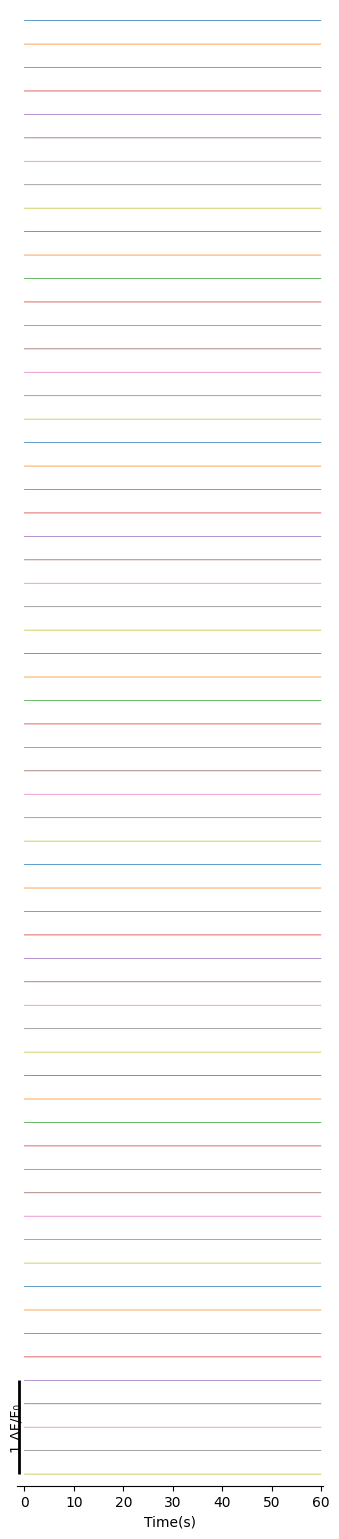

Error processing file CMTC-Sph10142024-PLate1_Stream_B03_s1_FITC_full: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)


/home/jesseh/miniforge3/envs/wizards_staff/lib/python3.11/site-packages/caiman/source_extraction/cnmf/deconvolution.py:1047: RuntimeWarning: divide by zero encountered in log
  'logmexp': lambda Pxx_ind: np.sqrt(np.exp(np.mean(np.log(Pxx_ind / 2))))


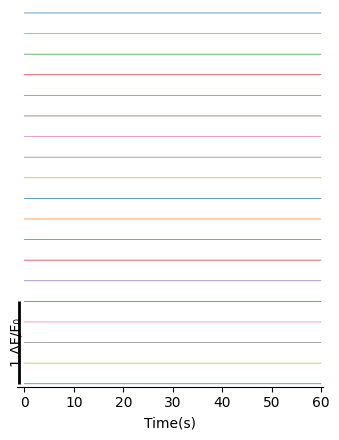

Error processing file CMTC-Sph10142024-PLate1_Stream_C02_s1_FITC_full: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)


/home/jesseh/miniforge3/envs/wizards_staff/lib/python3.11/site-packages/caiman/source_extraction/cnmf/deconvolution.py:1047: RuntimeWarning: divide by zero encountered in log
  'logmexp': lambda Pxx_ind: np.sqrt(np.exp(np.mean(np.log(Pxx_ind / 2))))


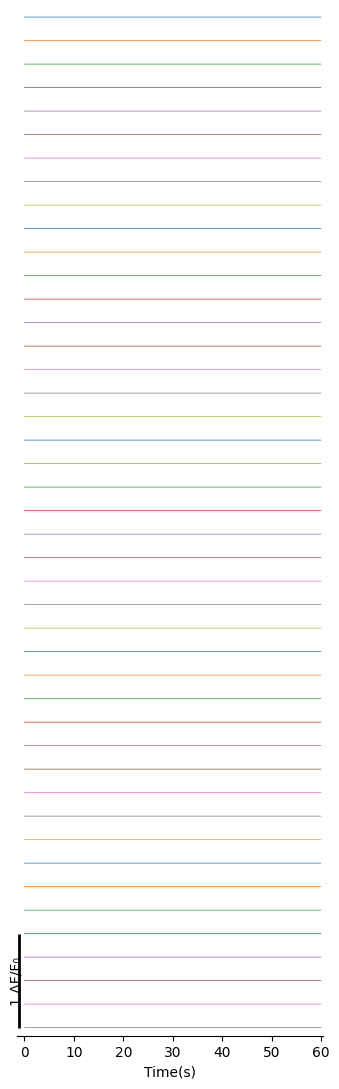

Error processing file CMTC-Sph10142024-PLate1_Stream_C03_s1_FITC_full: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)


KeyError: 'Filename'

In [1]:
import wizards_staff # import the module

# Path to the example data folder (update this path to your own data directory)
results_folder = '/large_storage/cmtc/public/CMTC-Sph10142024-PLate1/' # Folder containing the results of the Lizard_Wizard pipeline  
metadata_path = '/home/jesseh/metadata.csv' # Path to the metadata file
frate = 100  # Written in Frames Per Second

# Run the full analysis pipeline:
rise_time_df, fwhm_df, frpm_df, mask_metrics_df, silhouette_scores_df = wizards_staff.run_all(results_folder,  # Folder containing the results of the Lizard_Wizard pipeline
                                                                                            metadata_path, # Path to the metadata file
                                                                                            frate=frate, # Frame rate of the video
                                                                                            size_threshold=20000, # Parameter to filter out large noise 
                                                                                            show_plots = True, # Set to True to show the plots inline
                                                                                            save_files = False, # Set to True to save the output files
                                                                                            output_dir='./lizard_wizard_outputs' # Directory to save the output files
                                                                                            )

### Example 1b: Running the Full Analysis Pipeline with PWC
You can run the entire analysis pipeline including pairwise correlation calculations on a results folder by calling the `run_all` function and specifying a group name which is specified by a column name in your 'metadata_path' CSV file:

In [ ]:
import wizards_staff # import the module

results_folder = './path/to/results' # Folder containing the results of the Lizard_Wizard pipeline, update this path to your own data directory
metadata_path = './path/to/metadata.csv' # Path to the metadata file, update this path to your own metadata directory
frate = 30  # Written in Frames Per Second

# Run the full analysis pipeline:
rise_time_df, fwhm_df, frpm_df, mask_metrics_df, silhouette_scores_df = wizards_staff.run_all(results_folder,  # Folder containing the results of the Lizard_Wizard pipeline
                                                                                            metadata_path, # Path to the metadata file
                                                                                            frate=frate, # Frame rate of the video
                                                                                            group_name = 'group', # Column name in the metadata file containing the group information
                                                                                            size_threshold=20000, # Parameter to filter out large noise 
                                                                                            show_plots = True, # Set to True to show the plots inline
                                                                                            save_files = False, # Set to True to save the output files
                                                                                            output_dir='./lizard_wizard_outputs' # Directory to save the output files
                                                                                            )

### Example 2: Running just the PWC Function
You can run just the PWC pipeline on a results folder by calling the `run_pwc` function:

In [ ]:
import wizards_staff # import the module

group_name = 'Compound' # Column name in the metadata file containing the group information
results_folder = './path/to/results' # Folder containing the results of the Lizard_Wizard pipeline, update this path to your own data directory
metadata_path = './path/to/metadata.csv' # Path to the metadata file, update this path to your own metadata directory
poly = False # Set to True to fit a polynomial to the data

# Parameters for the function
df_mn_pwc, df_mn_pwc_inter, df_mn_pwc_intra = wizards_staff.run_pwc(group_name, # Column name in the metadata file containing the group information
                                                    metadata_path, 
                                                    results_folder, 
                                                    poly = poly, 
                                                    show_plots = False, # Set to True to show the plots inline
                                                    save_files = False, # Set to True to save the output files
                                                    output_dir = './lizard_wizard_outputs' # Default directory to save the output files
                                                    )

# df_mn_pwc
df_mn_pwc_inter
# df_mn_pwc_intra

### Example 3: Calculate just Firing Rate Per Minute

Below is a basic framework for how one would, instead of running through and calculating all metrics/plotting functions, just one module by:
- Gathering the necessary files for the analysis via `categorize_files`, which organizes the results from the Lizard-Wizard pipeline into a structured format for analysis.
- Looping through each file in the categorized results and loading the required data using `load_required_files`.
- Applying spatial filtering to remove noise in the calcium imaging data using `spatial_filtering`. This step filters the regions of interest (ROIs) based on the image data and thresholds defined, ensuring that only relevant signal areas are processed.
- Loading the ΔF/F₀ data, which represents fluorescence changes relative to baseline levels, and converting it to calcium signals and spike events using the `convert_f_to_cs` function.
- Z-scoring the spike events with `zscore` to normalize them, making the data easier to compare and threshold for event detection.
- Filtering the calcium signals and spike events based on the indexing results of `spatial_filtering`.
- Calculating the intended metric which in this case is Firing Rate Per Minute (FRPM) for each neuron using the `calc_frpm` function, which analyzes the z-scored spike events to compute firing rates based on the specified z-score threshold.
- Storing the FRPM data in a list, which is later converted to a pandas DataFrame for further analysis or visualization.

Finally, the metadata is appended to the resulting DataFrame using `append_metadata_to_dfs`, ensuring that each result is annotated with its corresponding metadata, such as image acquisition details and well positions from the plate.

In [ ]:
# Gather the necessary files for the analysis
categorized_files = categorize_files(results_folder)

# Initialize lists to store data for given metric type
frpm_data = []

# Loop through file list and run analysis on each file
for raw_filename, _ in tqdm(categorized_files.items(), desc="Processing files"):
    # Load the necessary Lizard_Wizard Output files for the current image file
    file_data = load_required_files(categorized_files, raw_filename)
    
    # Apply spatial filtering to the data to remove noise
    filtered_idx = spatial_filtering(cn_filter= file_data['cn_filter_img'], p_th = p_th, size_threshold = size_threshold, 
    cnm_A=file_data['cnm_A'], cnm_idx=file_data['cnm_idx'], im_min = file_data['im_min'], plot=False, silence=True)
    
    # Load the ΔF/F₀ data for the given image file and add a small constant to avoid division by zero``
    dff = file_data['dff_dat']
    dff += 0.0001  # Small constant added to avoid division by zero

    # Convert ΔF/F₀ to calcium signals and spike events
    calcium_signals, spike_events = convert_f_to_cs(dff, p = 2)

    # Z-score the spike events
    zscored_spike_events = zscore(np.copy(spike_events), axis = 1)

    # Filter the calcium signals and z-scored spike events based on the spatial filtering
    zscored_spike_events_filtered = zscored_spike_events[filtered_idx, :]
    calcium_signals_filtered = calcium_signals[filtered_idx, :]

    # Calculate FRPM:
    _, frpm  = calc_frpm(zscored_spike_events, filtered_idx, frate, zscore_threshold = zscore_threshold)

    # Append the FRPM data to the list
    for neuron_idx, frpm_value in frpm.items():
        frpm_data.append({'Filename': raw_filename,'Neuron Index': neuron_idx,'Firing Rate Per Min.': frpm_value})

# Convert the frpm list to DataFrames
frpm_df = pd.DataFrame(frpm_data)

# Append metadata to dataframes
updated_frpm_df = append_metadata_to_dfs(metadata_path, frpm = frpm_df)

# Show the first few rows of the updated DataFrame
updated_frpm_df.head()